In [79]:
import inspect
import requests
import json
import sys
from enum import Enum

In [80]:
_emulator_pre_prompt: str = (
    """
You will act as an emulator of impossible-to-code functions. I will provide you with the description of the function using Python's way of declaring functions, but I won't provide the function body as I don't know how to code it. It might even be impossible to code. Therefore, you should not try to write the body. Instead, directly imagine the function output.

In the conversation, I will directly write the function call as if it was called in Python. You should directly answer with whatever you believe would be a good return for the function.

When you produce an answer, you should estimate the confidence level:

    "low": You did your best, but with the provided description and your knowledge, you are not confident about the answer.
    "medium-instance": You did your best, and with the provided description and your knowledge, you are pretty sure this answer is valid but not the only valid answer.
    "medium-unique": You did your best, and with the provided description and your knowledge, you are pretty sure this answer is the unique and valid answer.
    "high-instance": You did your best, and you are sure that your provided answer is a valid answer. It is a well-known function or you can easily implement a Python code that yields elements from the list of valid answers. This answer is randomly chosen from the list of valid answers.
    "high-unique": You did your best, and you are sure that your provided answer is the unique valid answer. It is a well-known function or you can easily implement a Python code that solves the question and calculates this answer given this input.

If the output is documented as a Python structure, you should translate it to JSON.
You should encode the return in valid JSON format, without comments, using the following format:
{"return":..., "confidence":...}

The output must be of the same type as that specified in the function call.

Any assumptions made should be reasonable based on the provided function description and should take into account the error handling of the function.

Consistency in the confidence levels is important to ensure accurate responses.
This is the function documentation:

Example function call:

def example_function(a: int, b: dict) -> int:
    """
    """
    This is an example function.
    It adds two numbers.
    """
    """
    pass

Example imagined function output:

result = example_function(3, {"value": 7})

Expected JSON output:

{"return": 10, "confidence": "medium-unique"}

This is the function documentation:
"""
)

_enhancer_pre_prompt: str = """
I want you to become my Expert Prompt Creator for developer.
Your goal is to help me craft the best possible prompt for my programming needs.
The prompt you provide should be written from the perspective of me making the request to GPT-4o.
Consider in your prompt creation that this prompt will be entered into an interface for GPT-4o.
Apart from diagrams, you must write in text, without following any syntax.
The process is as follows:

You will generate the following sections:

"
-> enhanced:
{provide the best possible prompt according to my request. The prompt is used to describe
a function to be performed in Python as precisely as possible. You can add error handling,
as the function needs it to work properly. But don't code the function in the prompt.
The prompt should not tell to create the function, but describe how it works.}

-> review:
{provide a concise paragraph on how to improve the prompt. Be very critical in your response.
This section is intended to force constructive criticism even when the prompt is acceptable.
Any assumptions and or issues should be included. Don't forget that you speak to a developer}

-> advanced:
{rewrite the prompt with the suggested improvements you made in the critique category.
The aim is to make a proposal, an example. Make logical assumptions to solve
the problem based on the context and all the information you have. You have to respond
to the problems you formulated in the previous category. But don't code the function
in the prompt.}

-> mermaid:
{Make a mermaid diagram explaining the function described by the prompt. You need to break
the reasoning into several steps for ease of understanding and clarity. You must
make it logical and easy to look at. You have to write it in mermaid syntax.
You must not use the markdown syntax}
"
"""

In [81]:
_g_model = ""
_g_apiKey = ""

class Models(Enum):
    BEST = "gpt-4o"
    FAST = "gpt-4o"
    CHEAP = "gpt-4o"
    SECURE = "gpt-4o"
    
def model_config(model:Models, api_key:str)->int:
    global _g_model, _g_apiKey
    
    try:
        if not type(model) is Models:
            raise ValueError("ValueError -> model")
        if not type(api_key) is str:
            raise ValueError("ValueError -> api_key")
    except ValueError as v:
        sys.stderr.write(f"[CONFIG_ERROR] {v}")
        return -1
    finally: 
        _g_model = model.value
        _g_apiKey = api_key
    return 0

_exec_index:dict = {"auto": 0, "emulate": 1, "formulate": 2, "predict": 3, "build": 4}

In [82]:
time_array = []
score_array = []

In [83]:
def _ai_call_enh(sys_prompt: str, func_prot: str, func_doc: str):
    api_key = "sk-proj-T7o4z8S4q9fnBNTdSq4iT3BlbkFJ82uVDLRaIAkx1sjwyE5C"
    url = "https://api.openai.com/v1/chat/completions"

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}",
    }

    data = {
        "model": "gpt-4o",
        "messages": [
            {"role": "system", "content": [{"type": "text", "text": sys_prompt}]},
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "\nHere's my python function's prototype:\n---\n"
                        + func_prot
                        + "\n---\n",
                    }
                ],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "\nHere's my python function's prompt:\n---\n"
                        + func_doc
                        + "\n---\n",
                    }
                ],
            },
        ],
        "temperature": 0.7,
        "top_p": 0.7,
    }

    response = requests.post(url, headers=headers, data=json.dumps(data))

    if response.status_code == 200:
        response_data = response.json()
        return response_data["choices"][0]["message"]["content"]
    else:
        sys.stderr.write(
            "[CALL_ERROR] The request was unsuccessful or one of the parameters is invalid"
        )
        sys.stderr.write(f"Status: {response.status_code}")
        return None

def _parse_data(response: str, last_enh:dict)->dict:
    current_section = None
    current_text = []

    for line in response.splitlines():
        if line.startswith("->"):
            if current_section:
                last_enh[current_section] = "\n".join(current_text).strip()
            current_section = line[3:].strip(":")
            current_text = []
        else:
            current_text.append(line)
    if current_section:
        last_enh[current_section] = "\n".join(current_text).strip()
    return last_enh

def _build_attributes(func: object, last_enh) -> int:
    try:
        if not func.__name__ and not type(func.__name__) is str:
            raise ValueError("ValueError -> function name")
        if (
            not last_enh["enhanced"]
            and not type(last_enh["enhanced"]) is str
        ):
            raise ValueError("ValueError -> enhanced output")
        if (
            not last_enh["review"]
            and not type(last_enh["review"]) is str
        ):
            raise ValueError("ValueError -> review output")
        if (
            not last_enh["advanced"]
            and not type(last_enh["advanced"]) is str
        ):
            raise ValueError("ValueError -> seggested output")
        if (
            not last_enh["mermaid"]
            and not type(last_enh["mermaid"]) is str
        ):
            raise ValueError("ValueError -> mermaid output")
    except ValueError as e:
        sys.stderr.write(f"[BUILD_ERROR] {e}")
        return -1
    finally:
        func.enhanced_prompt = last_enh["enhanced"]
        func.review = last_enh["review"]
        func.advanced = last_enh["advanced"]
        func.diagramm = last_enh["mermaid"]
    return 0

def _enhance(func):
    global _enhancer_pre_prompt
    
    last_enh: dict = {
        "enhanced": None,
        "review": None,
        "advanced": None,
        "mermaid": None,
    }
    
    func_name, func_doc = func.__name__, func.__doc__

    last_return = _ai_call_enh(
        _enhancer_pre_prompt, func.__prot__, func_doc
    )
    
    last_enh = _parse_data(last_return, last_enh)
    
    _build_attributes(func, last_enh)


In [93]:
def emulate(_switch:bool=False, _function_doc=None, _function_call=None, warn:bool=False, creativity:float=None, diversity:float=None):
        if not _switch:
            global _exec_index
            return _exec_index["emulate"], warn, creativity, diversity
        else:
            global _emulator_pre_prompt, _g_model, _g_apiKey
            
            try:
                if not _emulator_pre_prompt or not _g_model or not _g_apiKey:
                    raise ValueError("ValueError -> emulate empty values")
                
                if (creativity is not None and (creativity < 0 or creativity > 1)) or (diversity is not None and (diversity < 0 or diversity > 1)):
                    raise ValueError("ValueError -> emulate out of range values (0<creativity|diversity<1)")
            except ValueError as v:
                print(f"[EMULATE_ERROR]: {v}")
                return None
            
            api_key = _g_apiKey
            l_body = {
                "model": _g_model,
                "messages": [
                    {
                        "role": "system",
                        "content": [
                            {
                                "type": "text",
                                "text": _emulator_pre_prompt
                                + "---\n"
                                + str(_function_doc)
                                + "\n---",
                            }
                        ],
                    },
                    {"role": "user", "content": [{"type": "text", "text": str(_function_call)}]},
                ],
                "response_format": {"type": "json_object"},
                "temperature": creativity if creativity is not None else 0.7,
                "top_p": diversity if diversity is not None else 0.7,
            }

            headers = {
                "Content-Type": "application/json",
                "Authorization": f"Bearer {api_key}",
            }

            response = requests.post(
                "https://api.openai.com/v1/chat/completions", json=l_body, headers=headers
            )

            __last_return__ = {"code": response.status_code, "text": response.text}

            __resp__ = response

            if response.status_code == 200:
                data = response.json()
                json_string = data["choices"][0]["message"]["content"]
                __last_content__ = json_string
                try:
                    l_ret_data = json.loads(json_string)
                    __jsonN__ = l_ret_data

                except json.JSONDecodeError as e:
                    print(f"JSONDecodeError: {e}")
                    l_cleand = "\n".join(json_string.split("\n")[1:-1])
                    l_ret_data = json.loads(l_cleand)

                __last_data__ = l_ret_data

                l_ret = l_ret_data["return"]
            else:
                print(f"Error {response.status_code}: {response.text}")
                __last_data__ = {"return": None, "confidence": "low"}
                l_ret = None

            return l_ret

def pmac(func):

    def wrapper(*args, **kwargs):
        
        global _exec_index
        temp:tuple = ()
        
        sig = inspect.signature(func)
        bound_args = sig.bind(*args, **kwargs)
        bound_args.apply_defaults()

        func_name = func.__name__
        func_params = ", ".join(
            [
                (
                    f"{param_name}: {param.annotation.__name__}"
                    if param.annotation != inspect.Parameter.empty
                    else param_name
                )
                for param_name, param in sig.parameters.items()
            ]
        )
        func_return = (
            f" -> {sig.return_annotation.__name__}"
            if sig.return_annotation != inspect.Signature.empty
            else ""
        )
        function_def = f"def {func_name}({func_params}):{func_return}\n    '''\n    {func.__doc__}\n    '''"

        func_call_args = ", ".join(
            [str(value) for value in bound_args.arguments.values()]
        )
        function_call = f"{func_name}({func_call_args})"
        
        wrapper.__prot__ = f"def {func_name}({func_params}):{func_return}"

        temp = func(*args, **kwargs)
        
        if temp[0] == _exec_index["emulate"]:
            try:
                result = emulate(_switch=True, _function_doc=function_def, _function_call=function_call, warn=temp[1], creativity=temp[2], diversity=temp[3])
            except Exception as e:
                print(Exception)
                print(f"[EMU_ERROR] {e}", function_call)
                result = None
            return result 
        else:
            print("[PMAC_ERROR] Unknown index for execution.")
            return None

    wrapper.__suggest__ = _enhance
    wrapper.__doc__ = func.__doc__
    wrapper.__name__ = func.__name__
    return wrapper

In [94]:
def thought(key):
    def inner_func(*args, **kwargs):
        try:
            result = emulate(True, _function_doc=key, _function_call=str(args[0]))
        except Exception as e:
            print(Exception)
            print("[LMDA_ERROR]")
            result = None
        return result
    return inner_func

In [95]:
model_config(model=Models.BEST, api_key="sk-proj-T7o4z8S4q9fnBNTdSq4iT3BlbkFJ82uVDLRaIAkx1sjwyE5C")

@pmac
def reverse_str_ia(a:str)->str:
    """
    This function reverse a string
    """  
    return emulate()

In [96]:
import time as t

def reverse_string(s):
    return s[::-1]

start = t.time()

word = "Bonjour"
result = reverse_str_ia(word)
print(result)

end = t.time()
duration = end - start

time_array.append(duration)

if result == reverse_string(word):
    score_array.append(True)
else:
    score_array.append(False)

reverse_str_ia(Bonjour) def reverse_str_ia(a: str): -> str
    '''
    
    This function reverse a string
    
    '''
ruojnoB


In [88]:
print(f"lambda direct: {thought("Assemble les mots d'un tableau")(["Bonjour", "je", "suis", "rouge"])}")


x = thought("Est-ce un prénom masculin")
print(f"Lamnda objet: {x("Emmanuel")}")

@pmac
def reverse_str_ia(a:str)->str:
    """
    This function reverse a string
    """  
    return emulate()

print(reverse_str_ia("Bonjour"))

lambda direct: Bonjour je suis rouge
Lamnda objet: True
ruojnoB


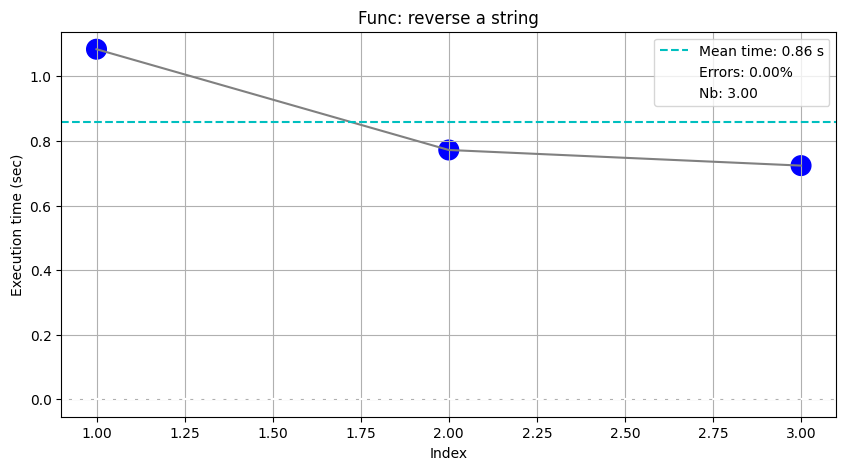

In [105]:
import matplotlib.pyplot as plt
import numpy as np


index = list(range(1, len(time_array) + 1))
colors = ['b'] * len(time_array)

for k in range(len(time_array)):
    if score_array[k] == True:
        colors[k] = 'b'
    else:
        colors[k] = 'r'

average_time = np.mean(time_array)

score = sum([1 if not x else 0 for x in score_array]) / len(score_array)

plt.figure(figsize=(10, 5))
plt.plot(index, time_array, linestyle='-', color='gray')

plt.scatter(index, time_array, color=colors, s=200)

plt.axhline(y=average_time, color='c', linestyle='--', label=f'Mean time: {average_time:.2f} s')
plt.axhline(y=0, color='w', linestyle='--', label=f'Errors: {score:.2f}%')
plt.axhline(y=0, color='w', linestyle='--', label=f'Nb: {len(score_array):.2f}')

plt.title('Func: reverse a string')
plt.xlabel('Index')
plt.ylabel('Execution time (sec)')

plt.grid(True)
plt.legend()
plt.show()

In [90]:
@pmac
def compute(a:int, b:int)->int:
    """
    This function mutlipies the two integers in parameter and add the first to the result
    """
    return emulate()

print(compute(5, 6))

compute.__suggest__(compute)
compute.diagramm

35


'graph TD\n    A[Start] --> B[Input: a, b]\n    B --> C{Are a and b integers?}\n    C -- No --> D[Raise TypeError]\n    C -- Yes --> E[Multiply a and b]\n    E --> F[Add a to the result]\n    F --> G[Return the final result]\n    G --> H[End]\n"'